In [194]:
import pandas as pd
from collections import defaultdict
from numpy import nan, mean, median
from statistics import mode
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Home Data pipeline

See [readme](../README.md) 2do section for next steps

In [195]:
# load data

global training___data, validation_data, training___price, validation_price, full_data, full_price, test_data, original_data, original_test_data, column_types
def load_data():
    global training___data, validation_data, training___price, validation_price, full_data, full_price, test_data, original_data, original_test_data, column_types
    column_types = defaultdict(lambda: None)
    test_data = pd.read_csv("./test.csv")
    original_test_data = test_data.copy()
    original_data = pd.read_csv("./train.csv")
    full_price = original_data.SalePrice
    training___data, validation_data, training___price, validation_price = train_test_split(original_data, full_price)
    training___data = training___data.drop("SalePrice", axis=1)
    validation_data = validation_data.drop("SalePrice", axis=1)
    full_data = original_data.drop("SalePrice", axis=1)

load_data()
training___data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
232,233,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,5,1972,1972,Gable,CompShg,HdBoard,HdBoard,BrkFace,297.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,483,483,GasA,TA,Y,SBrkr,483,504,0,987,0,0,1,1,2,1,TA,5,Typ,1,Po,Attchd,1972.0,Unf,1,288,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1056,1057,120,RL,43.0,7052,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,7,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,Stone,240.0,Gd,TA,PConc,Gd,TA,Av,GLQ,659,Unf,0,705,1364,GasA,Ex,Y,SBrkr,1364,0,0,1364,1,0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2005.0,RFn,2,484,TA,TA,Y,192,36,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
83,84,20,RL,80.0,8892,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1960,1960,Gable,CompShg,MetalSd,MetalSd,BrkCmn,66.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1065,1065,GasA,Gd,Y,SBrkr,1065,0,0,1065,0,0,1,1,3,1,TA,6,Typ,0,NaN,Detchd,1974.0,Unf,2,461,TA,TA,Y,74,0,0,0,0,0,NaN,NaN,NaN,0,7,2007,COD,Normal
1124,1125,80,RL,NaN,9125,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,SLvl,7,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,BrkFace,170.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,SBrkr,812,670,0,1482,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,1992.0,Fin,2,392,TA,TA,Y,100,25,0,0,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal
477,478,60,RL,105.0,13693,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,772.0,Ex,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,2153,2153,GasA,Ex,Y,SBrkr,2069,574,0,2643,0,0,2,1,3,1,Ex,9,Typ,1,Gd,BuiltIn,2006.0,Fin,3,694,TA,TA,Y,414,84,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,1105,160,RM,24.0,2016,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,TwnhsE,2Story,5,5,1970,1970,Gable,CompShg,HdBoard,HdBoard,BrkFace,304.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,630,630,GasA,TA,Y,SBrkr,630,672,0,1302,0,0,2,1,3,1,TA,6,Typ,0,NaN,Detchd,1970.0,Unf,2,440,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2007,WD,Normal
29,30,30,RM,60.0,6324,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Feedr,RRNn,1Fam,1Story,4,6,1927,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,520,520,GasA,Fa,N,SBrkr,520,0,0,520,0,0,1,0,1,1,Fa,4,Typ,0,NaN,Detchd,1920.0,Unf,1,240,Fa,TA,Y,49,0,87,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
317,318,60,FV,75.0,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,8,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1088,1088,GasA,Ex,Y,SBrkr,1088,871,0,1959,0,0,2,1,3,1,Gd,8,Typ,1,Gd,Attchd,2006.0,RFn,3,1025,TA,TA,Y,208,46,0,0,0,0,NaN,NaN,NaN,0,12,2007,WD,Normal
53,54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,NaN,0.0,Gd,TA,CBlock,Ex,TA,Gd,GLQ,1810,Unf,0,32,1842,GasA,Gd,Y,SBrkr,1842,0,0,1842,2,0,0,1,0,1,Gd,5,Typ,1,Gd,Attchd,198

In [196]:
full_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,2

In [197]:
# define possible column transformations

is_nan = lambda x: x != x
equals = lambda a, b: (is_nan(a) and is_nan(b)) or a == b
all_unique_values = lambda column_name: set(training___data[column_name].unique()) | set(validation_data[column_name].unique())
all_non_nan_values = lambda column_name: set(training___data[column_name].dropna().unique()) | set(validation_data[column_name].dropna().unique())

def drop(column_name, data_set, *_):
    data_set.drop(column_name, axis=1, inplace=True)
    return data_set

def drop_row(column_name, data_set, condition):
    return data_set[~data_set[column_name].apply(condition)]

def one_hot(column_name, data_set, options):
    keys = options if options else data_set[column_name].unique()
    for key in keys:
        column_types[f"{column_name}_{key}"] = "categorical"
        data_set[f"{column_name}_{key}"] = data_set[column_name].apply(lambda x: 1 if equals(x, key) else 0)
    return drop(column_name, data_set)

def apply(column_name, data_set, function):
    data_set[column_name] = data_set[column_name].apply(function)
    return data_set

def re_map(column_name, data_set, mapping):
    column_types[column_name] = "ordinal"
    data_set[column_name] = data_set[column_name].apply(lambda x: mapping[x])
    return data_set

def impute(column_name, data_set, function):
    imputation = function(data_set[column_name])
    data_set[column_name] = data_set[column_name].apply(lambda x: imputation if is_nan(x) else x)
    return data_set

def MSZoning(column_name, data_set, *_):
    options = dict(
        # A="Agriculture",
        # C="Commercial",
        FV="Floating Village Residential",
        # I="Industrial",
        RH="Residential High Density",
        RL="Residential Low Density",
        # RP="Residential Low Density Park",
        RM="Residential Medium Density",
    )
    for key, name in options.items():
        data_set[f"zoned_{name}"] = data_set[column_name].apply(lambda x: 1 if x in [key, "C (all)"] else 0)
        column_types[f"zoned_{name}"] = "categorical"
    return drop(column_name, data_set)

def neighborhood_median(column_name, data_set, *_):
    column_types[column_name] = "ordinal"
    neighborhood_medians = training___data[[column_name, "Neighborhood"]].groupby("Neighborhood").median().to_dict()[column_name]
    fn = lambda x: neighborhood_medians[x["Neighborhood"]] if is_nan(x[column_name]) else x[column_name]
    data_set[column_name] = data_set.apply(fn, axis=1)
    return data_set

def PoolQC(column_name, data_set, *_):
    column_types[column_name] = "ordinal"
    remap = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1}
    def fn(x):
        if x[column_name] in remap:
            return remap[x[column_name]]
        if x["PoolArea"] > 0:
            return 1 + (x["OverallQual"]-1)*3/9
        return 0
    data_set[column_name] = data_set.apply(fn, axis=1)
    return data_set

def masonry(column_name, data_set, *_):
    column_types[column_name] = "categorical"
    options = dict(
        BrkCmn="Brick Common",
        BrkFace="Brick Face",
        CBlock="Cinder Block",
        Stone="Stone",
    )
    for key in options:
        data_set[f"masonry {options[key]} sqft"] = 0
        for id in range(len(data_set)):
            if data_set[column_name].iloc[id] == key:
                value = data_set["MasVnrArea"].iloc[id]
                # ideally set the above set to the average of that type in that neighborhood (instead of the guess of 75)
                data_set[f"masonry {options[key]} sqft"].iat[id] = value if value > 2 else 75
    
    data_set[f"masonry other sqft"] = 0
    for id in range(len(data_set)):
        if is_nan(data_set["MasVnrType"].iloc[id]) and data_set["MasVnrArea"].iloc[id] > 2:
            data_set["masonry other sqft"].iat[id] = data_set["MasVnrArea"].iloc[id]

    data_set.drop(["MasVnrType", "MasVnrArea"], axis=1, inplace=True)
    return data_set

def fix_basement(data_set):
    basement_fields = [b for b in test_data.keys() if "Bsmt" in b]
    for row_id, row in data_set[basement_fields].iterrows():
        any_nulls = row.isnull().any()
        non_nulls = [type(i) == str for i in row]
        non_zeros = [i > 0 if type(i) in [float, int] else False for key, i in row.items()]
        if any_nulls and (any(non_nulls) or any(non_zeros)):
            for key, i in row.items():
                if is_nan(i):
                    data_set.at[row_id, key] = mode(data_set[key].dropna())

def basement(column_name, data_set, *_):
    fix_basement(data_set)
    options = dict(
        GLQ="Good Living Quarters",
        ALQ="Average Living Quarters",
        BLQ="Below Average Living Quarters",
        Rec="Average Rec Room",
        LwQ="Low Quality",
        Unf="Unfinished",
    )
    for key in options:
        data_set[f"basement {options[key]} sqft"] = 0
        column_types[f"basement {options[key]} sqft"] = "numeric"
        for id in range(len(data_set)):
            if data_set["BsmtFinType1"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF1"].iloc[id]
            if data_set["BsmtFinType2"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF2"].iloc[id]
    
    data_set.drop(["BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2"], axis=1, inplace=True)
    return data_set

def basement_unfinished(column_name, data_set, *_):
    unf1 = "basement Unfinished sqft"
    unf2 = "BsmtUnfSF"
    data_set[unf1] = data_set.apply(lambda x: x[unf1] + x[unf2], axis=1)
    
    data_set.drop(["BsmtUnfSF"], axis=1, inplace=True)
    return data_set

def garage_year(column_name, data_set, *_):
    data_set["GarageYrBlt"] = data_set.apply(lambda x: x["YearBuilt"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"], axis=1)
    return data_set

def NA_to_zero(column_name, data_set, *_):
    data_set[column_name] = data_set[column_name].apply(lambda x: 0 if is_nan(x) else x)
    return data_set

def bathz(column_name, data_set, *_):
    column_types[column_name] = "ordinal"
    cols = ["BsmtFullBath", "FullBath", "BsmtHalfBath", "HalfBath"]
    for col in cols:
        data_set = NA_to_zero(col, data_set)
    data_set[column_name] = data_set["BsmtFullBath"] + data_set["FullBath"] + 0.5*(data_set["BsmtHalfBath"] + data_set["HalfBath"])
    data_set.drop(cols, axis=1, inplace=True)
    return data_set

def condition12(column_name, data_set, *_):
    conditions = dict(
        Artery="Adjacent to arterial street",
        Feedr="Adjacent to feeder street",
        Norm="Normal",
        RRNn="Within 200' of North-South Railroad",
        RRAn="Adjacent to railroad",
        PosN="Near positive off-site feature",
        PosA="Adjacent to positive off-site feature",
        RRNe="Within 200' of East-West Railroad",
        RRAe="Adjacent to East-West Railroad",
    )
    for condition, label in conditions.items():
        data_set[label] = data_set.apply(lambda x: 1 if condition in [x["Condition1"], x["Condition2"]] else 0, axis=1)
        column_types[label] = "categorical"
    data_set.drop(["Condition1", "Condition2"], axis=1, inplace=True)
    return data_set

def is_new(column_name, data_set, *_):
    column_types[column_name] = "categorical"
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YrSold"] == x["YearBuilt"] else 0, axis=1)
    return data_set

def age(column_name, data_set, *_):
    column_types[column_name] = "ordinal"
    data_set[column_name] = data_set.apply(lambda x: x["YrSold"] - x["YearRemodAdd"], axis=1)
    return data_set

def remodeled(column_name, data_set, *_):
    column_types[column_name] = "categorical"
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YearBuilt"] != x["YearRemodAdd"] else 0, axis=1)
    return data_set

hoods = original_data[["SalePrice", "Neighborhood"]].groupby("Neighborhood").mean().sort_values("SalePrice").index.tolist()
def hood_check(i):
    if i < 3:
        return 0
    if i >= len(original_data["Neighborhood"].unique()) - 3:
        return 2
    return 1
bougieness = {hood: hood_check(i) for i, hood in enumerate(hoods)}

def total_sqft(column_name, data_set, *_):
    data_set[column_name] = data_set["TotalBsmtSF"] + data_set["GrLivArea"]
    data_set.drop(["TotalBsmtSF"], axis=1, inplace=True)
    return data_set

import inflation
def sale_price(column_name, data_set, *_):
    if column_name in data_set:
        for id in range(len(data_set)):
            data_set[column_name].iat[id] = inflation.adjust(
                price = data_set[column_name].iloc[id],
                from_year = data_set["YrSold"].iloc[id],
                from_month = data_set["MoSold"].iloc[id],
                to_year = 2010,
                to_month = 7,
            )
    data_set.drop(["MoSold", "YrSold"], axis=1, inplace=True)
    return data_set

def post_process(results, data_set, root_data):
    # global original_data
    output = []
    for id, price in enumerate(results):
        id_original = data_set["Id"].iloc[id]
        new_price = inflation.adjust(
            price=price,
            from_year=2010,
            from_month=7,
            to_year=int(root_data["YrSold"][root_data["Id"] == id_original].iloc[0]),
            to_month=int(root_data["MoSold"][root_data["Id"] == id_original].iloc[0]),
        )
        output.append(new_price)
    return results

In [198]:
# specify each column transformation

transformations = [
    ("MSSubClass", (one_hot, all_unique_values("MSSubClass"))),
    ("MSZoning", (impute, mode)),
    ("MSZoning", (MSZoning, None)),
    ("LotFrontage", (neighborhood_median, None)),
    ("Street", (re_map, {"Pave": 1, "Grvl": 0})),
    ("Alley", (drop, None)),
    ("LotShape", (re_map, {"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 3})),
    # "LandContour": (re_map, {"Lvl": 1, "Bnk": 3, "HLS": 2, "Low": 0}),
    ("LandContour", (one_hot, all_unique_values("LandContour"))),
    ("Utilities", (drop, None)),
    ("LotConfig", (one_hot, all_unique_values("LotConfig"))),
    ("LandSlope", (re_map, {"Gtl": 2, "Mod": 1, "Sev": 0})),
    ("Neighborhood", (re_map, bougieness)),
    ("Conditions", (condition12, None)),
    ("BldgType", (one_hot, all_unique_values("BldgType"))),
    ("HouseStyle", (one_hot, all_unique_values("HouseStyle"))),
    ("RoofStyle", (one_hot, all_unique_values("RoofStyle"))),
    ("RoofMatl", (one_hot, all_unique_values("RoofMatl"))),
    ("Exterior1st", (impute, mode)),
    ("Exterior1st", (one_hot, all_unique_values("Exterior1st"))),
    ("Exterior2nd", (drop, None)),
    ("MasVnrType", (masonry, None)),
    ("ExterQual", (re_map, {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})),
    ("ExterCond", (re_map, {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})),
    ("Foundation", (one_hot, all_unique_values("Foundation"))),
    ("TotalBsmtSF", (NA_to_zero, None)),
    ("BsmtUnfSF", (NA_to_zero, None)),
    ("TotalBsmtSF", (basement, None)),
    ("BsmtQual", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0})),
    ("BsmtCond", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0})),
    ("BsmtExposure", (re_map, {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0, nan: 0})),
    ("BsmtUnfSF", (basement_unfinished, None)),
    ("bathz", (bathz, None)),
    ("Heating", (one_hot, all_unique_values("Heating"))),
    ("HeatingQC", (re_map, {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})),
    ("CentralAir", (re_map, {"Y": 1, "N": 0})),
    ("Electrical", (re_map, {"SBrkr": 4, "FuseA": 3, "FuseF": 2, "FuseP": 1, "Mix": 0, nan: 0})),
    ("KitchenQual", (impute, mode)),
    ("KitchenQual", (re_map, {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})),
    ("Functional", (impute, mode)),
    ("Functional", (re_map, {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0})),
    ("FireplaceQu", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0})),
    ("GarageType", (one_hot, all_non_nan_values("GarageType"))),
    ("GarageYrBlt", (garage_year, None)),
    ("GarageFinish", (re_map, {"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0, nan: 0})),
    ("GarageCars", (NA_to_zero, None)),
    ("GarageQual", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0})),
    ("GarageCond", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0})),
    ("PavedDrive", (re_map, {"Y": 2, "P": 1, "N": 0})),
    ("PoolQC", (PoolQC, None)),
    ("Fence", (one_hot, all_unique_values("Fence"))),
    ("MiscFeature", (drop, None)),
    ("SaleType", (impute, mode)),
    ("SaleType", (one_hot, all_unique_values("SaleType"))),
    ("SaleCondition", (one_hot, all_unique_values("SaleCondition"))),
    ("Age", (age, None)),
    ("IsNew", (is_new, None)),
    ("YrSold", (one_hot, all_unique_values("YrSold"))),
    ("MoSold", (one_hot, all_unique_values("MoSold"))),
    ("YearBuilt", (drop, None)),
    ("YearRemodAdd", (drop, None)),
    ("TotalSqft", (total_sqft, None)),
]

In [199]:
def manual_transformations():
    for col in ["GarageFinish", "GarageQual", "GarageCond"]:
        test_data[col].iat[666] = mode(test_data[col])
    test_data["GarageType"].iat[1116] = nan
    test_data["GarageArea"].iat[1116] = 0

In [200]:
# apply column transformations to data
load_data()
for column_name, (transform, option) in transformations:
    print("transforming", column_name)
    training___data = transform(column_name, training___data, option)
    full_data = transform(column_name, full_data, option)
    validation_data = transform(column_name, validation_data, option)
    test_data = transform(column_name, test_data, option)

validation_data

transforming MSSubClass
transforming MSZoning
transforming MSZoning
transforming LotFrontage
transforming Street
transforming Alley
transforming LotShape
transforming LandContour
transforming Utilities
transforming LotConfig
transforming LandSlope
transforming Neighborhood
transforming Conditions
transforming BldgType
transforming HouseStyle
transforming RoofStyle
transforming RoofMatl
transforming Exterior1st
transforming Exterior1st
transforming Exterior2nd
transforming MasVnrType
transforming ExterQual
transforming ExterCond
transforming Foundation
transforming TotalBsmtSF
transforming BsmtUnfSF
transforming TotalBsmtSF
transforming BsmtQual
transforming BsmtCond
transforming BsmtExposure
transforming BsmtUnfSF
transforming bathz
transforming Heating
transforming HeatingQC
transforming CentralAir
transforming Electrical
transforming KitchenQual
transforming KitchenQual
transforming Functional
transforming Functional
transforming FireplaceQu
transforming GarageType
transforming Garag

,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_20,MSSubClass_85,MSSubClass_90,MSSubClass_30,MSSubClass_160,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_180,MSSubClass_120,MSSubClass_60,MSSubClass_190,zoned_Floating Village Residential,zoned_Residential High Density,zoned_Residential Low Density,zoned_Residential Medium Density,LandContour_Lvl,LandContour_Low,LandContour_HLS,LandContour_Bnk,LotConfig_Inside,LotConfig_FR3,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Corner,Adjacent to arterial street,Adjacent to feeder street,Normal,Within 200' of North-South Railroad,Adjacent to railroad,Near positive off-site feature,Adjacent to positive off-site feature,Within 200' of East-West Railroad,Adjacent to East-West Railroad,BldgType_TwnhsE,BldgType_Duplex,BldgType_Twnhs,BldgType_1Fam,BldgType_2fmCon,HouseStyle_SFoyer,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Unf,HouseStyle_2.5Fin,HouseStyle_1Story,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_Gable,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,RoofMatl_ClyTile,RoofMatl_Membran,RoofMatl_WdShake,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Tar&Grv,RoofMatl_Roll,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_AsbShng,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_ImStucc,Exterior1st_VinylSd,Exterior1st_Plywood,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_BrkFace,Exterior1st_HdBoard,Exterior1st_Stucco,Exterior1st_Stone,Exterior1st_Wd Sdng,Exterior1st_WdShing,masonry Brick Common sqft,masonry Brick Face sqft,masonry Cinder Block sqft,masonry Stone sqft,masonry other sqft,Foundation_Slab,Foundation_Wood,Foundation_PConc,Foundation_Stone,Foundation_BrkTil,Foundation_CBlock,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,bathz,Heating_Floor,Heating_GasW,Heating_Wall,Heating_Grav,Heating_GasA,Heating_OthW,GarageType_CarPort,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,GarageType_2Types,GarageType_Attchd,Fence_MnWw,Fence_GdPrv,Fence_GdWo,Fence_nan,Fence_MnPrv,SaleType_New,SaleType_WD,SaleType_Oth,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_COD,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Alloca,SaleCondition_Family,Age,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalSqft
492,493,105.0,15578,1,1,2,1,6,5,3,2,4,3,1,3,1,4,728,728,0,1456,3,1,2,8,7,0,0,2006.0,2,2,429,3,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,728,2.5,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2184
230,231,73.0,8760,1,0,2,1,6,6,2,2,3,3,1,2,1,4,1194,0,0,1194,3,1,2,6,7,0,0,1959.0,2,1,312,3,3,2,0,0,120,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,220,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1194,2.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,51.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,2388
891,892,70.0,11184,1,0,2,1,6,5,2,2,3,3,1,3,1,4,918,765,0,1683,3,1,2,7,7,1,3,1978.0,2,2,440,3,3,2,243,0,0,0

In [201]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(test_data)

,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_20,MSSubClass_85,MSSubClass_90,MSSubClass_30,MSSubClass_160,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_180,MSSubClass_120,MSSubClass_60,MSSubClass_190,zoned_Floating Village Residential,zoned_Residential High Density,zoned_Residential Low Density,zoned_Residential Medium Density,LandContour_Lvl,LandContour_Low,LandContour_HLS,LandContour_Bnk,LotConfig_Inside,LotConfig_FR3,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Corner,Adjacent to arterial street,Adjacent to feeder street,Normal,Within 200' of North-South Railroad,Adjacent to railroad,Near positive off-site feature,Adjacent to positive off-site feature,Within 200' of East-West Railroad,Adjacent to East-West Railroad,BldgType_TwnhsE,BldgType_Duplex,BldgType_Twnhs,BldgType_1Fam,BldgType_2fmCon,HouseStyle_SFoyer,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Unf,HouseStyle_2.5Fin,HouseStyle_1Story,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_Gable,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,RoofMatl_ClyTile,RoofMatl_Membran,RoofMatl_WdShake,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Tar&Grv,RoofMatl_Roll,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_AsbShng,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_ImStucc,Exterior1st_VinylSd,Exterior1st_Plywood,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_BrkFace,Exterior1st_HdBoard,Exterior1st_Stucco,Exterior1st_Stone,Exterior1st_Wd Sdng,Exterior1st_WdShing,masonry Brick Common sqft,masonry Brick Face sqft,masonry Cinder Block sqft,masonry Stone sqft,masonry other sqft,Foundation_Slab,Foundation_Wood,Foundation_PConc,Foundation_Stone,Foundation_BrkTil,Foundation_CBlock,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,bathz,Heating_Floor,Heating_GasW,Heating_Wall,Heating_Grav,Heating_GasA,Heating_OthW,GarageType_CarPort,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,GarageType_2Types,GarageType_Attchd,Fence_MnWw,Fence_GdPrv,Fence_GdWo,Fence_nan,Fence_MnPrv,SaleType_New,SaleType_WD,SaleType_Oth,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_COD,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Alloca,SaleCondition_Family,Age,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalSqft
0,1461,80.0,11622,1,0,2,1,5,6,2,2,3,3,1,2,1,4,896,0,0,896,2,1,2,5,7,0,0,1961.0,1,1.0,730.0,3,3,2,140,0,0,0,120,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,468,144,270.0,1.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,49.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1778.0
1,1462,81.0,14267,1,1,2,1,6,6,2,2,3,3,1,2,1,4,1329,0,0,1329,3,1,3,6,7,0,0,1958.0,1,1.0,312.0,3,3,2,393,36,0,0,0,0,0.0,12500,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,108,0,0,0,0,0,0,0,0,1,0,923,0,0,0,406.0,1.5,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,52.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,2658.0
2,1463,74.0,13830,1,1,2,1,5,5,2,2,4,3,1,3,1,4,928,701,0,1629,3,1,2,6,7,1,3,1

# find correlated variables for dropping

In [202]:
corr = None
corr = full_data.copy()
corr["SalePrice"] = training___price
corr = corr.corr(method="spearman")
corr.dropna(axis=0, how="all", inplace=True)

both_corr = None
both_corr = pd.DataFrame(columns=full_data.keys())
# both_corr = pd.concat([training___data, test_data])
both_corr = pd.concat([both_corr, test_data])
both_corr = both_corr.corr(method="spearman")
both_corr.dropna(axis=0, how="all", inplace=True)

/tmp/ipykernel_30693/2459956485.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  both_corr = pd.concat([both_corr, test_data])


In [203]:
both_corr

,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_20,MSSubClass_85,MSSubClass_90,MSSubClass_30,MSSubClass_160,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_180,MSSubClass_120,MSSubClass_60,MSSubClass_190,zoned_Floating Village Residential,zoned_Residential High Density,zoned_Residential Low Density,zoned_Residential Medium Density,LandContour_Lvl,LandContour_Low,LandContour_HLS,LandContour_Bnk,LotConfig_Inside,LotConfig_FR3,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Corner,Adjacent to arterial street,Adjacent to feeder street,Normal,Within 200' of North-South Railroad,Adjacent to railroad,Near positive off-site feature,Adjacent to positive off-site feature,Within 200' of East-West Railroad,Adjacent to East-West Railroad,BldgType_TwnhsE,BldgType_Duplex,BldgType_Twnhs,BldgType_1Fam,BldgType_2fmCon,HouseStyle_SFoyer,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Unf,HouseStyle_2.5Fin,HouseStyle_1Story,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_Gable,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,RoofMatl_ClyTile,RoofMatl_Membran,RoofMatl_WdShake,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Tar&Grv,RoofMatl_Roll,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_AsbShng,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_ImStucc,Exterior1st_VinylSd,Exterior1st_Plywood,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_BrkFace,Exterior1st_HdBoard,Exterior1st_Stucco,Exterior1st_Stone,Exterior1st_Wd Sdng,Exterior1st_WdShing,masonry Brick Common sqft,masonry Brick Face sqft,masonry Cinder Block sqft,masonry Stone sqft,masonry other sqft,Foundation_Slab,Foundation_Wood,Foundation_PConc,Foundation_Stone,Foundation_BrkTil,Foundation_CBlock,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,bathz,Heating_Floor,Heating_GasW,Heating_Wall,Heating_Grav,Heating_GasA,Heating_OthW,GarageType_CarPort,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,GarageType_2Types,GarageType_Attchd,Fence_MnWw,Fence_GdPrv,Fence_GdWo,Fence_nan,Fence_MnPrv,SaleType_New,SaleType_WD,SaleType_Oth,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_COD,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Alloca,SaleCondition_Family,Age,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalSqft
Id,1.000000,-0.014887,0.011641,0.003001,0.002316,0.009410,-0.098702,-0.066390,0.007193,-0.071361,-0.021450,-0.056173,-0.022073,0.051018,-0.028770,-0.036594,-0.037375,-0.015600,-0.011467,0.002839,-0.041460,0.009060,-0.017051,-0.062399,-0.000997,-0.067446,-0.045993,-0.046673,-0.056502,-0.041034,-0.056270,-0.046637,-0.054069,-0.037122,-0.030846,-0.007128,-0.022590,0.022598,-0.021769,0.036491,0.041897,0.041798,-0.019466,0.024766,0.010951,0.005425,-0.017664,0.025158,-0.011876,0.000662,-0.026834,0.027710,-0.002085,0.021854,0.046607,-0.039304,-0.000416,0.027422,-0.063453,-0.007587,0.028164,0.033953,-0.042825,0.023912,0.040372,0.006672,0.005003,0.017101,0.019770,-0.030510,-0.008778,-0.023622,0.016624,-0.009196,-0.041300,0.042668,-0.044800,0.024361,-0.009274,0.011282,-0.029874,-0.011876,-0.008663,0.021059,0.027196,0.048874,-0.017265,0.007798,0.027790,0.025006,0.016971,NaN,-0.028026,-0.026298,0.048930,0.008229,0.004734,0.000019,-0.011553,NaN,NaN,0

In [204]:
indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")
high_corr

,SalePrice,TotalSqft,OverallQual,GrLivArea,bathz,GarageCars,ExterQual,KitchenQual,BsmtQual,GarageArea,GarageFinish,GarageYrBlt,Age,Foundation_PConc,1stFlrSF,FireplaceQu,TotRmsAbvGrd,Fireplaces,Neighborhood
SalePrice,1.000000,0.808294,0.798717,0.727588,0.702359,0.698122,0.694713,0.682782,0.682495,0.663182,0.642487,0.618324,-0.592453,0.568864,0.567060,0.539232,0.531634,0.517743,0.514166
TotalSqft,0.808294,1.000000,0.655684,0.869057,0.610746,0.573071,0.524066,0.496593,0.507785,0.565760,0.457168,0.385595,-0.356228,0.381773,0.753769,0.502548,0.676489,0.493839,0.450966
OverallQual,0.798717,0.655684,1.000000,0.603262,0.557466,0.608756,0.715988,0.660498,0.673048,0.541552,0.567090,0.622280,-0.563396,0.586764,0.408730,0.481197,0.427806,0.420626,0.464701
GrLivArea,0.727588,0.869057,0.603262,1.000000,0.604521,0.505094,0.446430,0.427784,0.388268,0.468211,0.388025,0.293149,-0.290551,0.332373,0.494421,0.480506,0.827874,0.480804,0.362957
bathz,0.702359,0.610746,0.557466,0.604521,1.000000,0.529361,0.494642,0.487101,0.562690,0.493908,0.495813,0.498576,-0.415571,0.446188,0.358812,0.311082,0.453237,0.344650,0.351536
GarageCars,0.698122,0.573071,0.608756,0.505094,0.529361,1.000000,0.542498,0.520308,0.551884,0.853317,0.548214,0.648543,-0.463009,0.480178,0.450580,0.357182,0.386244,0.325520,0.432260
ExterQual,0.694713,0.524066,0.715988,0.446430,0.494642,0.542498,1.000000,0.725266,0.645766,0.484655,0.536103,0.662905,-0.633348,0.632657,0.337444,0.352144,0.300065,0.262436,0.459916
KitchenQual,0.682782,0.496593,0.660498,0.427784,0.487101,0.520308,0.725266,1.000000,0.575112,0.484536,0.480438,0.600192,-0.659362,0.567626,0.340988,0.348324,0.285377,0.264540,0.403901
BsmtQual,0.682495,0.507785,0.673048,0.388268,0.562690,0.551884,0.645766,0.575112,1.000000,0.464520,0.555535,0.723384,-0.591744,0.663624,0.301489,0.317001,0.224725,0.262486,0.388138
GarageArea,0.663182,0.565760,0.541552,0.468211,0.493908,0.853317,0.484655,0.484536,0.464520,1.000000,0.474226,0.616982,-0.400177,0.400205,0.489797,0.288576,0.330549,0.264543,0.394443


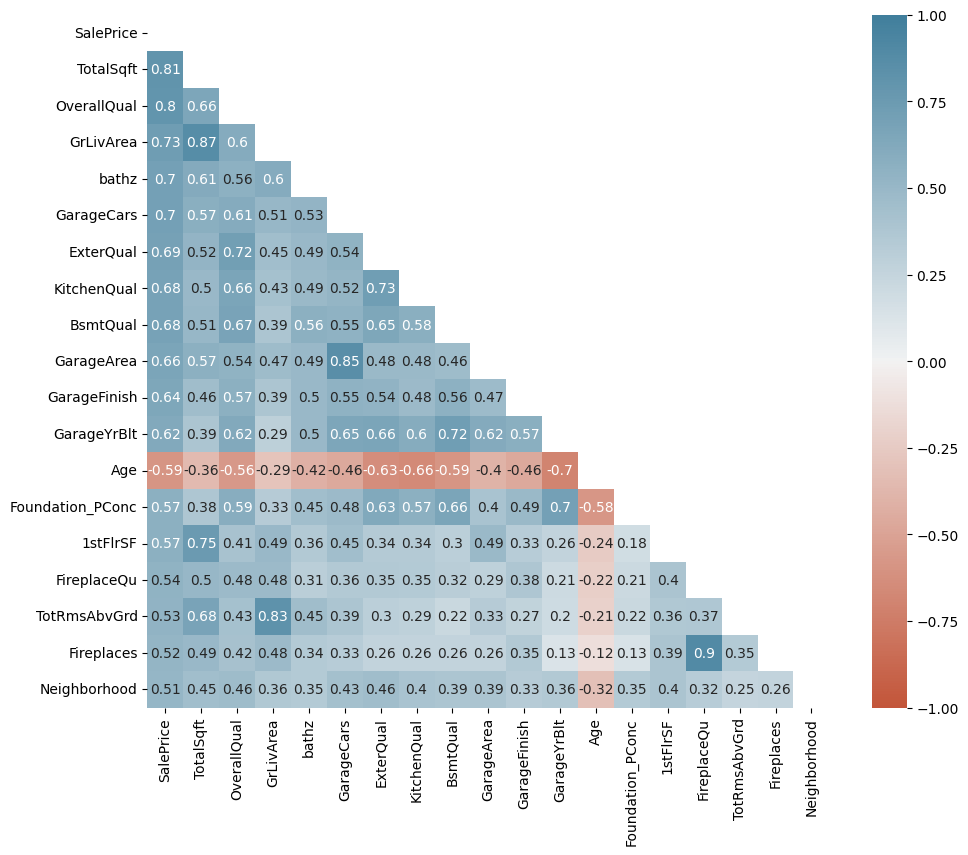

In [205]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")

plt.subplots(figsize=(11, 9))
sns.heatmap(high_corr,
    mask=np.triu(np.ones_like(high_corr, dtype=bool)),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    vmax=1, vmin=-1, center=0,
    annot=True,
)
None

In [206]:
correlations = dict()
for col1, item in dict(both_corr).items():
    for col2, value in dict(item).items():
        if col1 == col2:
            continue
        key1, key2 = sorted([col1, col2])
        correlations[(key1, key2)] = value

correlations = sorted(correlations.items(), reverse=True, key=lambda x: abs(x[1]))
limit = 20
n = 0
for (key1, key2), value in correlations:
    if n >= limit:
        break
    if "categorical" in [column_types[key1], column_types[key2]]:
        continue
    print(key1, f"({column_types[key1]})", key2, f"({column_types[key2]})", value)
    n += 1

PoolArea (None) PoolQC (ordinal) 0.9999914305690188
FireplaceQu (ordinal) Fireplaces (None) 0.9119689084599036
GarageArea (None) GarageCars (None) 0.8753249851295483
GrLivArea (None) TotalSqft (None) 0.8554384253160949
GrLivArea (None) TotRmsAbvGrd (None) 0.7879615206076269
BsmtQual (ordinal) GarageYrBlt (None) 0.7541870797915317
1stFlrSF (None) TotalSqft (None) 0.7499580718362355
Age (ordinal) GarageYrBlt (None) -0.7434626636447637
GarageCond (ordinal) GarageQual (ordinal) 0.7285746977820429
ExterQual (ordinal) KitchenQual (ordinal) 0.7230928141059323
ExterQual (ordinal) OverallQual (None) 0.7198399307127961
ExterQual (ordinal) GarageYrBlt (None) 0.6964277910133885
BsmtQual (ordinal) OverallQual (None) 0.6851980002688471
Age (ordinal) ExterQual (ordinal) -0.6753856581053315
BsmtQual (ordinal) ExterQual (ordinal) 0.670045136527642
GarageYrBlt (None) OverallQual (None) 0.6626855202905827
KitchenQual (ordinal) OverallQual (None) 0.6603168626227187
BedroomAbvGr (None) TotRmsAbvGrd (None) 

In [207]:
drop_correlated_columns = [
    "Id", # not useful
    "MSSubClass_90", # correlates exactly with BldgType_Duplex
    "GarageArea", # correlates strongly with GarageCars (which correlates better with SalePrice)
    "TotRmsAbvGrd", # correlates strongly with GrLivArea (which correlates better with SalePrice)
    # "Age", # correlates strongly with GarageYrBlt (which correlates better with SalePrice)
]

# Find sparse data for dropping

In [208]:
columns_with_same_val = set([col for col in full_data.columns if len(full_data.index) - max(full_data[col].value_counts()) < 20 or len(test_data.index) - max(test_data[col].value_counts()) < 20])
output = pd.DataFrame(columns=["column", "type", "training occurrences", "test occurrences", "mode", "decision", "total"])
drop_saturated_columns = []
for i, col in enumerate(columns_with_same_val):
    non_similar_full = len(full_data.index) - max(full_data[col].value_counts())
    non_similar_test = len(test_data.index) - max(test_data[col].value_counts())
    dr0p = non_similar_full == 0 or non_similar_test == 0 or non_similar_full + non_similar_test < 19 and column_types[col] == "categorical"
    popular_value = full_data[col].value_counts().idxmax()
    output.loc[i+1] = [col, column_types[col], non_similar_full, non_similar_test, popular_value, "🔪" if dr0p else "👍", non_similar_full + non_similar_test]
    if dr0p:
        drop_saturated_columns.append(col)
output.sort_values("total").reset_index(drop=True)

,column,type,training occurrences,test occurrences,mode,decision,total
0,masonry Cinder Block sqft,None,0,0,0,🔪,0
1,Heating_Floor,categorical,1,0,0,🔪,1
2,Exterior1st_ImStucc,categorical,1,0,0,🔪,1
3,RoofMatl_Membran,categorical,1,0,0,🔪,1
4,RoofMatl_ClyTile,categorical,1,0,0,🔪,1
5,RoofMatl_Metal,categorical,1,0,0,🔪,1
6,RoofMatl_Roll,categorical,1,0,0,🔪,1
7,Exterior1st_CBlock,categorical,1,1,0,🔪,2
8,Exterior1st_AsphShn,categorical,1,1,0,🔪,2
9,Exterior1st_Stone,categorical,2,0,0,🔪,2


In [214]:
drop_columns = list(set(["Id"] + drop_correlated_columns + drop_saturated_columns))
drop_columns, len(drop_columns)

(['GarageArea',
  'Heating_Grav',
  'MSSubClass_45',
  'RoofMatl_WdShngl',
  'Exterior1st_Stone',
  'Foundation_Stone',
  'SaleType_ConLw',
  'RoofStyle_Shed',
  'TotRmsAbvGrd',
  'Exterior1st_CBlock',
  'Exterior1st_ImStucc',
  'Heating_Floor',
  'masonry Cinder Block sqft',
  'SaleType_ConLI',
  'Fence_MnWw',
  'Foundation_Wood',
  'GarageType_CarPort',
  'Exterior1st_BrkComm',
  'Id',
  'RoofMatl_WdShake',
  "Within 200' of North-South Railroad",
  'SaleType_Con',
  'MSSubClass_90',
  'MSSubClass_180',
  'SaleCondition_AdjLand',
  'RoofMatl_Membran',
  'Heating_OthW',
  'RoofStyle_Mansard',
  'Heating_Wall',
  'LotConfig_FR3',
  'MSSubClass_40',
  'RoofMatl_Roll',
  'HouseStyle_2.5Fin',
  'RoofMatl_ClyTile',
  'RoofMatl_Metal',
  'SaleType_CWD',
  "Within 200' of East-West Railroad",
  'SaleType_Oth',
  'Exterior1st_AsphShn'],
 39)

# Fit, cross-validate, & compare

In [217]:
from xgboost import XGBRegressor
from sigfig import round
pretty = lambda x: round(str(x), decimals=2, spacer=",", spacing=3)
from sklearn.metrics import mean_absolute_error
from capture_output import Capturing
from random import shuffle

load_data()
for column_name, (transform, option) in transformations:
    full_data = transform(column_name, full_data, option)

outlier_ids = [523, 1298]
full_data = full_data.drop(outlier_ids).reset_index(drop=True)
full_price = full_price.drop(outlier_ids).reset_index(drop=True)
print(f"Dropped {len(original_data) - len(full_data)} rows")

def generate_cross_validation_sets(full_data, sets=5):
    indicies = [i for i in range(len(full_data))]
    shuffle(indicies)
    set_size = len(full_data) // sets
    for n in range(sets):
        yield indicies[n*set_size:(n+1)*set_size]

errors = []
iterations = []
for indicies_subset in generate_cross_validation_sets(full_data, sets=5):
    training___data = full_data.drop(indicies_subset)
    training___price = full_price.drop(indicies_subset)
    validation_data = full_data.iloc[indicies_subset]
    validation_price = full_price.iloc[indicies_subset]

    model = None
    model = XGBRegressor(n_estimators=1_000, learning_rate=0.05, early_stopping_rounds=5)
    with Capturing() as output:
        model.fit(training___data.drop(drop_columns, axis=1), training___price, eval_set=[(validation_data.drop(drop_columns, axis=1), validation_price)])

    predictions = model.predict(validation_data.drop(drop_columns, axis=1))

    error = float(mean_absolute_error(validation_price, predictions))
    print(f"Error: {pretty(error)}", f"Iterations: {len(output)}")
    errors.append(error)
    iterations.append(len(output))

print(f"Mean Absolute Error: {pretty(mean(errors))}")
print(f"Optimal # Iterations(?): {mean(iterations)}")

Dropped 2 rows
Error: 17,231.62 Iterations: 312
Error: 15,014.76 Iterations: 182
Error: 14,796.18 Iterations: 128
Error: 14,649.75 Iterations: 172
Error: 17,685.94 Iterations: 243
Mean Absolute Error: 15,875.65
Optimal # Iterations(?): 207.4


# Generate Output

In [211]:
from xgboost import XGBRegressor

load_data()
manual_transformations()
for column_name, (transform, option) in transformations:
    full_data = transform(column_name, full_data, option)
    test_data = transform(column_name, test_data, option)

model = None
model = XGBRegressor(n_estimators=1_000, learning_rate=0.05)
model.fit(full_data.drop(drop_columns, axis=1), full_price)

predictions = model.predict(test_data.drop(drop_columns, axis=1))

submission = pd.DataFrame({'Id': test_data.index + 1461, 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
submission

,Id,SalePrice
0,1461,116110.312500
1,1462,166560.234375
2,1463,183435.156250
3,1464,186686.468750
4,1465,184244.468750
...,...,...
1454,2915,79616.078125
1455,2916,81272.679688
1456,2917,155321.031250
1457,2918,121023.187500


In [212]:
# manual validation
from itertools import chain
# load_data()
m_fields = [g for g in test_data.keys() if "masonry" in g] + ["Id"]
# for id, row in chain(test_data[garage_fields].iterrows(), full_data[garage_fields].iterrows()):
#     if row.isnull().any():
#         if any([type(i) == str for i in row]) or any([i > 0 if type(i) in [float, int] and key != "Id" else False for key, i in row.items()]):
#             print(row)
Idz = [1670, 2320, 2453, 2611, 625, 689, 774, 1231, 1242, 1301, 1335]
output = pd.DataFrame(columns=full_data.keys())
for s3t in test_data, full_data:
    output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])
output[m_fields]
# full_data.drop("Id", axis=1).isnull().values.any()
output = pd.DataFrame(columns=full_data.keys())
for id, row in test_data.iterrows():
    if row.isnull().any():
        output = pd.concat([output, test_data[test_data["Id"] == row["Id"]]])
# test_data.isnull().any(axis=1).sum()
output
column_types
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     #get ready to wait 75 seconds
#     display(full_data)
full_data[full_data["Id"].isin([813,939,826])]

/tmp/ipykernel_30693/77202551.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])


,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_20,MSSubClass_85,MSSubClass_90,MSSubClass_30,MSSubClass_160,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_180,MSSubClass_120,MSSubClass_60,MSSubClass_190,zoned_Floating Village Residential,zoned_Residential High Density,zoned_Residential Low Density,zoned_Residential Medium Density,LandContour_Lvl,LandContour_Low,LandContour_HLS,LandContour_Bnk,LotConfig_Inside,LotConfig_FR3,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Corner,Adjacent to arterial street,Adjacent to feeder street,Normal,Within 200' of North-South Railroad,Adjacent to railroad,Near positive off-site feature,Adjacent to positive off-site feature,Within 200' of East-West Railroad,Adjacent to East-West Railroad,BldgType_TwnhsE,BldgType_Duplex,BldgType_Twnhs,BldgType_1Fam,BldgType_2fmCon,HouseStyle_SFoyer,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Unf,HouseStyle_2.5Fin,HouseStyle_1Story,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_Gable,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,RoofMatl_ClyTile,RoofMatl_Membran,RoofMatl_WdShake,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Tar&Grv,RoofMatl_Roll,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_AsbShng,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_ImStucc,Exterior1st_VinylSd,Exterior1st_Plywood,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_BrkFace,Exterior1st_HdBoard,Exterior1st_Stucco,Exterior1st_Stone,Exterior1st_Wd Sdng,Exterior1st_WdShing,masonry Brick Common sqft,masonry Brick Face sqft,masonry Cinder Block sqft,masonry Stone sqft,masonry other sqft,Foundation_Slab,Foundation_Wood,Foundation_PConc,Foundation_Stone,Foundation_BrkTil,Foundation_CBlock,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,bathz,Heating_Floor,Heating_GasW,Heating_Wall,Heating_Grav,Heating_GasA,Heating_OthW,GarageType_CarPort,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,GarageType_2Types,GarageType_Attchd,Fence_MnWw,Fence_GdPrv,Fence_GdWo,Fence_nan,Fence_MnPrv,SaleType_New,SaleType_WD,SaleType_Oth,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_COD,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Alloca,SaleCondition_Family,Age,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalSqft
812,813,66.0,8712,0,0,1,0,5,5,1,2,3,3,3,2,0,3,1044,0,0,1044,2,1,1,4,7,0,0,1952.0,1,2,504,3,3,0,0,0,0,0,0,0,0,54,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,540,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,58.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1584
825,826,114.0,14803,1,0,2,2,10,5,4,2,5,3,3,4,1,4,2084,0,0,2084,2,1,4,7,7,1,4,2007.0,3,3,1220,3,3,2,188,45,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,816,0,0,0,0,0,1,0,0,0,1636,0,0,0,0,442,3.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4162
938,939,73.0,8760,1,0,2,1,7,5,3,2,4,4,2,4,1,4,1391,571,0,1962,3,1,3,7,7,0,0,2006.0,2,3,868,3,3,2,0,90